# Ensemble Learning through Soft Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [52]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

## Parameter Configuration

In [53]:
np.random.seed(2020)

In [54]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [55]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [56]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [57]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [58]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07910258689366288

In [59]:
X_test.shape

(100000, 1, 2)

## Compare with Hard voting

In [60]:

x  =  X_test[1023]
for predictor in soft.predictors:
    print(predictor.predict(x,return_std=True))
print(soft.predictors[0].kernel)
print(soft.predictors[1].kernel)

(array([-0.00066049]), array([0.0251005]))
(array([-0.00975121]), array([0.02114459]))
(array([0.00518251]), array([0.01971414]))
RBF(length_scale=39.2) + WhiteKernel(noise_level=2.5)
RBF(length_scale=39.2) + WhiteKernel(noise_level=2.5)


In [61]:
from sklearn.base import clone
gpr1  = GaussianProcessRegressor(kernel,copy_X_train=False)
gpr2  = clone(gpr1)
gpr1.fit(flatten_X(X_train[2:10]),y_train[2:10])
gpr2.fit(flatten_X(X_train[12:20]),y_train[12:20])

print(gpr1.predict(X_test[4],return_std = True))
print(gpr2.predict(X_test[4],return_std = True))

(array([0.11668687]), array([0.05785658]))
(array([0.06577228]), array([0.10983612]))


## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [63]:
#reference error: no ensemble
from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],5,100000,MaxCallStochasticModel)
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 196
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.13086691022172817
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.13817958560035468
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.13132754510418426
{'M': 1, 'train_size_alpha': 1.0} , 3 -> 0.15150196515433031
{'M': 1, 'train_size_alpha': 1.0} , 4 -> 0.11094627911072956
{'M': 1, 'train_size_alpha': 1.0} -> [0.13086691022172817, 0.13817958560035468, 0.13132754510418426, 0.15150196515433031, 0.11094627911072956]
0.1325644570382654


In [64]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SoftBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.3,0.5,0.7,1.0]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(10) #avoid allocation issues
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 17360
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 25400
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.7} -> thread id = 24348
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 26612
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.3} -> thread id = 12732
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.5} -> thread id = 16960
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.7} -> thread id = 26608
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 1.0} -> thread id = 32688
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.3} -> thread id = 29228
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.5} -> thread id = 19200
fit
(5000, 2)
 soft predict
(100000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 0 -> 0.1525564999284104
 soft predict
(100000, 2)
 soft predict
(100000, 2)
 soft predict
(100000, 2)
 soft predict
(100000, 2)
 soft predict
(100000, 2)
 soft predict
(100000, 2)
 soft predict
(100000, 2)
 soft predict
(100000, 2)
{'M': 

{'M': 9, 'train_size_alpha': 0.3} , 1 -> 0.1292361768076397
 soft predict
(100000, 2)
{'M': 7, 'train_size_alpha': 0.7} , 1 -> 0.18256480630292943
 soft predict
(100000, 2)
{'M': 9, 'train_size_alpha': 0.7} , 0 -> 0.1951043278971003
 soft predict
(100000, 2)
{'M': 7, 'train_size_alpha': 1.0} , 1 -> 0.15232353078032496
 soft predict
(100000, 2)
{'M': 9, 'train_size_alpha': 1.0} , 0 -> 0.1612979784450929
 soft predict
(100000, 2)
{'M': 9, 'train_size_alpha': 0.3} , 2 -> 0.09365253974234454
{'M': 9, 'train_size_alpha': 0.3} -> [0.11304398590912017, 0.1292361768076397, 0.09365253974234454]
logger {'M': 9, 'train_size_alpha': 0.3}, -> [0.11304398590912017, 0.1292361768076397, 0.09365253974234454]
{'M': 9, 'train_size_alpha': 0.5} , 1 -> 0.17706418411744582
 soft predict
(100000, 2)
{'M': 7, 'train_size_alpha': 0.7} , 2 -> 0.1941994932296979
{'M': 7, 'train_size_alpha': 0.7} -> [0.1298149296376791, 0.18256480630292943, 0.1941994932296979]
logger {'M': 7, 'train_size_alpha': 0.7}, -> [0.12981

In [65]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.3, [0.1525564999284104, 0.1425420466028954, 0.14204151581790173]]
[1, 0.5, [0.2291749702497835, 0.2138239063752975, 0.23410544756269064]]
[1, 0.7, [0.19677829434556182, 0.23465847893755157, 0.22283463200419018]]
[1, 1.0, [0.2229014145638589, 0.1933416097905648, 0.2061329336790418]]
[3, 0.3, [0.09975858963989764, 0.10812822621445646, 0.11424949776700731]]
[3, 0.5, [0.15501316312841512, 0.2068305065839296, 0.19050357124882442]]
[3, 0.7, [0.19308646031233626, 0.18483295096537167, 0.21686397247567588]]
[3, 1.0, [0.18757815656675947, 0.17815500671003562, 0.2001686360902455]]
[5, 0.3, [0.09902594148249327, 0.13175905629929593, 0.1060177496990605]]
[5, 0.5, [0.1829161565843053, 0.13675382073554523, 0.18076194824237624]]
[5, 0.7, [0.2155569281085588, 0.20264834110513003, 0.16564465380219326]]
[7, 0.3, [0.11612265100514142, 0.1451174920682789, 0.131723481455133]]
[5, 1.0, [0.15937607501372897, 0.13309208410590512, 0.16110680453973084]]
[7, 0.5, [0.17232772269909477, 0.1691815351275852, 0.

In [66]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 4)

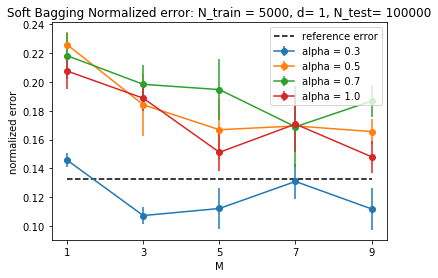

In [67]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Soft Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.show()

## Store results

In [17]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [18]:
import json
import datetime
with open(f'soft_bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)